In [1]:
import os
import pandas as pd
import csv

import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
%matplotlib inline

import folium
import json

from IPython.display import display

In [2]:
p_info_table = pd.read_csv("/home/kh/19Fall/Corona/data/PatientInfo.csv", parse_dates = ['confirmed_date'])
region = pd.read_csv("/home/kh/19Fall/Corona/data/Region.csv")
p_route_table = pd.read_csv("~/19Fall/Corona/data/travel_route.csv")

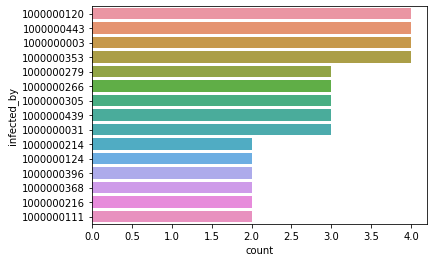

,infected_by,infection_case,count
24,1000000120,contact with patient,4
53,1000000353,contact with patient,4
64,1000000443,contact with patient,4
1,1000000003,contact with patient,4
62,1000000439,contact with patient,3
10,1000000031,contact with patient,3
49,1000000305,contact with patient,3
43,1000000266,contact with patient,3
44,1000000279,contact with patient,3
42,1000000264,contact with patient,2


In [3]:
# spreader_count = dict()
spreader_count = None
spreader_count = p_info_table[['infected_by']]\
    .dropna(axis = 0).astype('int64')\
    .groupby('infected_by')['infected_by'].count().reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)

top_spreader = spreader_count.head(15)
sns.barplot(x = 'count',y = 'infected_by',
            data = top_spreader, orient = 'h',
            order = top_spreader['infected_by'])
plt.show()

spreader_count = p_info_table[['infected_by', 'infection_case']]\
    .dropna(axis = 0)\
    .astype({'infected_by' : 'int64'})\
    .groupby(['infected_by', 'infection_case'])['infected_by'].count()\
    .reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)
spreader_count.head(15)

In [4]:
infection_count = p_info_table[['infected_by', 'infection_case']]\
    .dropna(axis = 0)\
    .astype({'infected_by' : 'int64'})\
    .groupby(['infection_case'])['infection_case'].count()\
    .reset_index(name = 'count')\
    .sort_values(['count'], ascending = False)
infection_count

,infection_case,count
3,contact with patient,105
0,Eunpyeong St. Mary's Hospital,6
5,overseas inflow,3
1,Guro-gu Call Center,2
2,Seongdong-gu APT,2
4,etc,1


### visualize infection route using BFS

In [5]:
class Order:
    def __init__(self, rect_size = 0.004, rows = 10, cols = 10):
        self.region_count = dict() 
        self.patient_pos = dict() 
        for city in region['city']:
            self.region_count[city] = 0
        self.rows = rows
        self.cols = cols
        self.lat_interval = rect_size / (rows + 1)  
        self.long_interval = rect_size / (cols + 1) 
        self.lat_init = rect_size / 2 - self.lat_interval    
        self.long_init = -rect_size / 2 + self.long_interval 
        self.epsilons = np.arange(-self.lat_interval/4, self.lat_interval/4, self.lat_interval/ cols)
        self.epsilon_len = len(self.epsilons)
        
    def set_loc(self, patient_id, city_name):
        num = None
        epsilon = None
        if patient_id in self.patient_pos:
            num, epsilon = self.patient_pos[patient_id]
        else:
            num = self.region_count[city_name]
            epsilon = self.epsilons[np.random.randint(self.epsilon_len)]
            self.patient_pos[patient_id] = (num, epsilon)
            self.region_count[city_name] += 1
        row = num // self.rows
        col = num % self.rows
        latitude_jit = self.lat_init - self.lat_interval * row + epsilon
        longitude_jit = self.long_init + self.long_interval * col
        return latitude_jit, longitude_jit

def get_location(info):
    info = info.reset_index()
    region_info = None
    city = info.loc[0, 'city']
    province = info.loc[0, 'province']
    if city is np.nan or city ==  'etc':
        region_info = region[region['province'] == province]
    else:
        region_info = region[(region['province'] == province) & (region['city'] == city)]
    return region_info.reset_index().loc[0, ['latitude', 'longitude']]

def get_city_name(info):
    info = info.reset_index()
    if info.loc[0, 'city'] is np.nan or info.loc[0, 'city'] ==  'etc':
        return info.loc[0, 'province']
    else:
        return info.loc[0, 'city']

# spreading levels : 1st to 6th level
depth_color = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']


def draw_spreading_line(spreader, patient, depth, m, order):
    spreader_info = p_info_table[p_info_table['patient_id'] == spreader]
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    spreader_pos = list(get_location(spreader_info))
    patient_pos = list(get_location(patient_info))
    spreader_city = get_city_name(spreader_info)
    patient_city = get_city_name(patient_info)

    jit_s_lat, jit_s_long = order.set_loc(spreader, spreader_city)
    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    color = (lambda x : depth_color[depth] if type(x) is int else x)(depth)

    if(depth == 0): ### first-order spreader
        inform = (
            str(spreader)
            + ' ('+ spreader_info['province'].to_string(index = False)
            + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
            + ') start'
        )
        spreader_case = spreader_count[spreader_count['infected_by'] == spreader]
        for i in range(len(spreader_case)):
            case = spreader_case.iloc[i]
            where = case['infection_case']
            count = case['count']
            inform += f'<br>{count: 3} patients : {where}'

        lat = spreader_pos[0] + jit_s_lat
        longi = spreader_pos[1] + jit_s_long
        folium.CircleMarker(
            location=(lat, longi), 
            fill_color = color,
            fill_opacity =1.0,
            color = color,
            radius=4,
            weight = 2,
            tooltip = inform
        ).add_to(m)

    inform = (
        str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' infected by '
        + str(spreader)
        + ' ('+ spreader_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
    )

    if spreader_pos == patient_pos: 
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
        folium.CircleMarker(
            location=patient_pos, 
            fill_color = color,
            color = color,
            radius=4, 
            weight = 2,
            tooltip = inform
        ).add_to(m)
    else: 
        spreader_pos[0] += jit_s_lat
        spreader_pos[1] += jit_s_long
        patient_pos[0] += jit_p_lat
        patient_pos[1] += jit_p_long
        folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
        folium.RegularPolygonMarker(
            location=patient_pos, 
            fill_color=color,
            fill_opacity = 0.2,
            color =  color,
            number_of_sides=4, 
            radius=7, 
            weight = 2,
            tooltip = inform
        ).add_to(m)

def draw_no_spreader(spreader, patient, depth, m, order):
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    patient_pos = list(get_location(patient_info))
    patient_city = get_city_name(patient_info)

    inform = (
        str(spreader)
        + ' ( ??? ) ->'
        + str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
    )

    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    patient_pos[0] += jit_p_lat
    patient_pos[1] += jit_p_long
    color = (lambda x : depth_color[x] if type(x) is int else cycle_color)(depth)
    folium.CircleMarker(
        location=patient_pos, 
        fill_color = color,
        color = color,
        radius=4, 
        weight = 2,
        tooltip = inform
    ).add_to(m)

def draw_cycle(spreader, patient, color, m, order):
    spreader_info = p_info_table[p_info_table['patient_id'] == spreader]
    patient_info = p_info_table[p_info_table['patient_id'] == patient]
    spreader_pos = list(get_location(spreader_info))
    patient_pos = list(get_location(patient_info))
    spreader_city = get_city_name(spreader_info)
    patient_city = get_city_name(patient_info)

    inform = (
        str(patient)
        + ' ('+ patient_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['city'])
        + ' infected by '
        + str(spreader)
        + ' ('+ spreader_info['province'].to_string(index = False)
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(spreader_info['city'])
        + ' )<br>infection case : '
        + (lambda x : x.to_string(index = False) if x.values[0] is not np.nan else '')(patient_info['infection_case'])
    )

    jit_s_lat, jit_s_long = order.set_loc(spreader, spreader_city)
    jit_p_lat, jit_p_long = order.set_loc(patient, patient_city)
    spreader_pos[0] += jit_s_lat; spreader_pos[1] += jit_s_long
    patient_pos[0] += jit_p_lat; patient_pos[1] += jit_p_long

    folium.PolyLine(
            locations = [spreader_pos, patient_pos],
            color = color,
            weight = 1,
            tooltip = inform
        ).add_to(m)
    folium.CircleMarker(            
        location=patient_pos, 
        fill_color = color,
        fill_opacity =1.0,
        color = color,
        radius=4,
        weight = 2,
        tooltip = inform
    ).add_to(m)

In [6]:
patient_and_spreader = p_info_table[['patient_id', 'infected_by']].dropna(axis = 0).astype('int64')
infection_route = dict()
rir = dict()
for i in patient_and_spreader.index:
    patient = patient_and_spreader.loc[i, 'patient_id']
    spreader = patient_and_spreader.loc[i, 'infected_by']
    
    rir[patient] = spreader
    if spreader in infection_route:
        infection_route[spreader].append(patient)        
    else:
        infection_route[spreader] = [patient]

# rir : reverse infection route

### set tree
spreader_root = set() ### tree root node set
cycles = [] ###cycle list
for spreader in infection_route.keys():
    maybe_cycle = [spreader]
    while spreader in rir:
        spreader = rir[spreader]
        ### start to eliminate cycle
        if spreader in maybe_cycle:
            idx = maybe_cycle.index(spreader)
            candidate = maybe_cycle[idx:]            
            for cycle in cycles: 
                for node in candidate: 
                    if node not in cycle: 
                        break 
                else: 
                    if len(cycle) == len(candidate): break 
            else: 
                cycles.append(maybe_cycle[idx:])
            break
        ### End cycle
        maybe_cycle.append(spreader)
    spreader_root.add(spreader)

In [7]:
center = [36.641876, 127.488759]
rect_size = 0.004  
display_order = Order(rect_size, 10, 10) 
m = folium.Map(location=center
               , zoom_start=8
               , tiles = 'cartodbpositron'
               )
# drawing reactangular
for i in range(len(region)):
    if i == len(region) - 1: 
        continue             
    loc = region.loc[i, ['latitude', 'longitude']]
    province = region.loc[i, ['province']].to_string(index = False) 
    city = region.loc[i, ['city']].to_string(index = False) 
    inform = (province + ' ' + (lambda x : x if x != province else '')(city))

    folium.Rectangle(
        bounds = (loc + [rect_size / 2, -rect_size/2]
                  , loc + [-rect_size/2, rect_size/2]), 
        radius = 180,
        color = 'black',
        fill_color='black',
        tooltip = inform
    ).add_to(m)

# BFS strats
print('case 1 : No spreader information')
visited = []
queue = []
for starter in spreader_root:
    visited.append(starter)
    queue.append((starter, 0))

while len(queue) > 0:
    spreader, depth = queue[0]
    queue.pop(0)
    for patient in infection_route[spreader]:
        try:
            draw_spreading_line(spreader, patient, depth, m, display_order)
        except KeyError:
            print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
            draw_no_spreader(spreader, patient, depth, m, display_order)
        if patient in infection_route and patient not in visited:
            queue.append((patient, depth +1))
            visited.append(patient)

# display cycle
print('\ncase 2 : cycle starts')
n = 1
for cycle in cycles:
    print(f'cycle {n}')
    n+=1
    for node in cycle:
        patient = p_info_table.loc[p_info_table['patient_id'] == node, ['patient_id', 'infected_by']].astype('int64').values[:]
        print(f'patient {patient[0, 0]} infected by {patient[0, 1]}') 
    
    cycle.append(cycle[0])          
    for i in range(len(cycle)-1):
        try:
            draw_cycle(cycle[i], cycle[i+1], 'white', m, display_order)
        except:
            print('spreader id does not exist : ' + str(spreader) + ' patient : ' + str(patient))
    cycle.pop()   

case 1 : No spreader information
spreader id does not exist : 2002000001 patient : 1000000003
spreader id does not exist : 1500000002 patient : 1000000040
spreader id does not exist : 2017000005 patient : 1000000062

case 2 : cycle starts


In [8]:
m